In [25]:
import tempfile

from torchrl.data import ReplayBuffer

buffer = ReplayBuffer()
len(buffer)
buffer.extend(range(2000))
len(buffer)

# Storage:
from torchrl.data import LazyMemmapStorage, LazyTensorStorage, ListStorage

size = 100

buffer_list = ReplayBuffer(storage=ListStorage(size), collate_fn=lambda x: x)
buffer_list.extend(["a", 0, "b"])
print(buffer_list.sample(3))
buffer_lazytensor = ReplayBuffer(storage=LazyTensorStorage(size))

import torch as th
from tensordict import TensorDict

data = TensorDict({
    "a": th.arange(12).view(3, 4),
    ("b", "c"): th.arange(15).view(3, 5)
}, [3])
print(data)

# with extend now we initialize the buffer
buffer_lazytensor.extend(data)
print(f"the buffer has {len(buffer_lazytensor)} elements")
sample = buffer_lazytensor.sample(5)
print("samples", sample["a"], "\n", sample["b", "c"])

buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size))
buffer_lazymemmap.extend(data)

print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazytensor.sample(5)
print("samples: a=", sample["a"], "\n('b', 'c'):", sample["b", "c"])

tempdir = tempfile.TemporaryDirectory()
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size, scratch_dir=tempdir))
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
print("the 'a' tensor is stored in", buffer_lazymemmap._storage._storage["a"].filename)
print(
    "the ('b', 'c') tensor is stored in",
    buffer_lazymemmap._storage._storage["b", "c"].filename,
)

[0, 'a', 0]
TensorDict(
    fields={
        a: Tensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: Tensor(shape=torch.Size([3, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([3]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([3]),
    device=None,
    is_shared=False)
the buffer has 3 elements
samples tensor([[ 0,  1,  2,  3],
        [ 0,  1,  2,  3],
        [ 0,  1,  2,  3],
        [ 0,  1,  2,  3],
        [ 8,  9, 10, 11]]) 
 tensor([[ 0,  1,  2,  3,  4],
        [ 0,  1,  2,  3,  4],
        [ 0,  1,  2,  3,  4],
        [ 0,  1,  2,  3,  4],
        [10, 11, 12, 13, 14]])
The buffer has 3 elements
samples: a= tensor([[ 8,  9, 10, 11],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [ 8,  9, 10, 11],
        [ 0,  1,  2,  3]]) 
('b', 'c'): tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]

In [27]:
from torchrl.data import TensorDictReplayBuffer

tempdir = tempfile.TemporaryDirectory()
buffer_lazymemmap = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir=tempdir), batch_size=12
)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazymemmap.sample()
print("sample:", sample)
print(sample["index"])

# With custom data
from tensordict import tensorclass


@tensorclass
class MyData:
    images: th.Tensor
    labels: th.Tensor


# fixed batch-size ->fixed return on sample
data = MyData(
    images=th.randint(
        255,
        (200, 64, 64, 3),
    ),
    labels=th.randint(100, (200,)),
    batch_size=[200],
)

buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size), batch_size=128)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazymemmap.sample()
print("sample:", sample)

The buffer has 3 elements
sample: TensorDict(
    fields={
        a: Tensor(shape=torch.Size([12, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: Tensor(shape=torch.Size([12, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([12]),
            device=cpu,
            is_shared=False),
        index: Tensor(shape=torch.Size([12]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([12]),
    device=cpu,
    is_shared=False)
tensor([0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0])
The buffer has 100 elements
sample: MyData(
    images=Tensor(shape=torch.Size([128, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([128]),
    device=cpu,
    is_shared=False)


In [28]:
for i, data in enumerate(buffer_lazymemmap):
    if i == 3:
        print(data)
        break


MyData(
    images=Tensor(shape=torch.Size([128, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=Tensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([128]),
    device=cpu,
    is_shared=False)


In [33]:
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement

buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size), batch_size=32, sampler=SamplerWithoutReplacement()
)

data = TensorDict(
    {
        "a": th.arange(64).view(16, 4),
        ("b", "c"): th.arange(128).view(16, 8),
    },
    batch_size=[16],
)

buffer_lazymemmap.extend(data)
print(len(buffer_lazymemmap))
for _i, data in enumerate(buffer_lazymemmap):
    print(data)
    continue
print(f"A total of {_i + 1} batches have been collected")

16
TensorDict(
    fields={
        a: Tensor(shape=torch.Size([16, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: Tensor(shape=torch.Size([16, 8]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([16]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([16]),
    device=cpu,
    is_shared=False)
A total of 1 batches have been collected


# Prioritized Replay Buffers

In [0]:
from torchrl.data.replay_buffers.samplers import PrioritizedSampler

size = 100

rb = ReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(max_capacity=size, alpha=0.8, beta=1.1),
    collate_fn=lambda x: x
)

indices = rb.extend([1, "foo", None])
rb.update_priority(index=indices, priority=th.tensor([0, 1_000, 0.1]))
sample, info = rb.sample(10, return_info=True)
print(sample)
print(info)

(array([ 37.,  24.,  77.,  67.,  75., 138.,  88., 180.,  96., 242.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

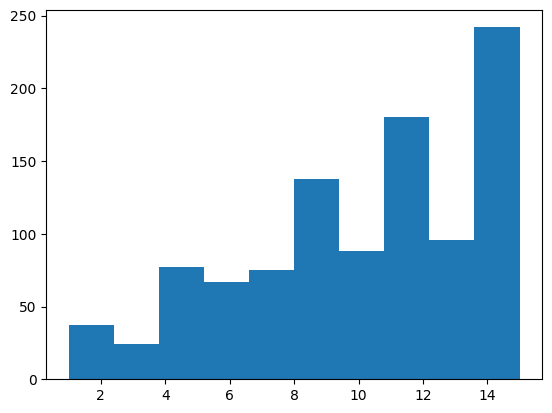

In [81]:
""" Auto Update Weights with loss from sample and loss
>>> data = replay_buffer.sample()
>>> loss_val = loss_module(data)
>>> replay_buffer.update_tensordict_priority(data)
"""

rb = TensorDictReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(size, alpha=0.8, beta=1.1),
    priority_key="td_error",
    batch_size=1024,
)

# higher values have higher error so higher prob
data["td_error"] = th.arange(data.numel())

rb.extend(data)

sample = rb.sample()

from matplotlib import pyplot as plt

plt.hist(sample["index"].numpy())

(array([217., 123., 184.,  85.,  79., 138.,  55.,  86.,  34.,  23.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

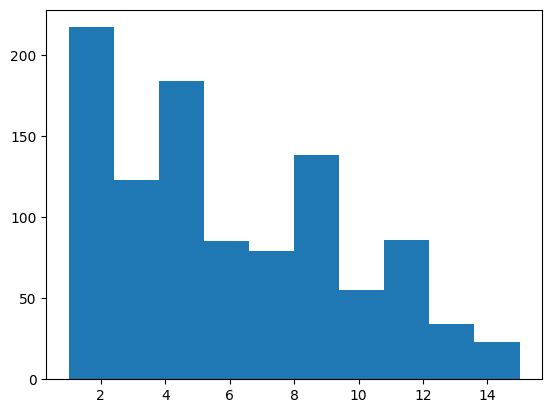

In [84]:
sample = rb.sample()
# higher values have lower error so lower prob
sample["td_error"] = data.numel() - sample["index"]
rb.update_tensordict_priority(sample)

sample = rb.sample()
from matplotlib import pyplot as plt

plt.hist(sample["index"].numpy())
